# Diamond Price Analysis
---
### Authors:
* Marcin Bereźnicki
* Jakub Burczyk
---
### The problem:
The purpose of the project was to analyze diamond's pricing based on it's weight.

### The goal:
We hope, that after creating sufficient model it will be possible to predict a price for gem given it's mass in carats. 

It may be possible to estimate a price without any trade specific knowledge for example about type of cuts, which could prevent getting ripped off by sellers/buyers.

---

# Table of contents
We highly recommend using provided hyperlinks to sections.

* [Dataset](#dataset)
* [Python modules](#imports)
* [Data Tidying](#data-tidying)
  * [Dropping indexes](#dropping-index)
  * [Mass and price extraction](#mass-and-price-extraction)
  * [Plotting dataset and polynomial fitting](#plotting-dataset-and-polynomial-fitting)
* [Data Analysis](#data-analysis)
  * [Loading dataset](#loading-dataset)
  * [Model 1 - 1st degree polynomial regression](#model-1---linear-regression---1st-degree)
    * [Prior predictive check](#model-1---prior-predictive-check)
    * [Posterior analysis](#model-1---posterior-analysis)
    * [Linear regression](#model-1---stan-linear-regression)
    * [Model parameters](#model-1---model-parameters)
    * [Evaluation](#model-1---evaluation)
      * [Quantiles](#model-1---quantiles)
      * [Predictions and density](#model-1---predictions-and-density-plot)
  * [Model Comparison](#model-comparison)
    * [PSIS-LOO Criterion](#psis-loo-criterion)
    * [WAIC Criterion](#waic-criterion)
    * [Conclusions](#model-comparison---conclusions)

---
# Dataset
[***Return to table of contents***](#table-of-contents)

The data was sourced from [Kaggle.com](https://www.kaggle.com/) which is an online community of data scientists. The dataset can be downloaded [**here**](https://www.kaggle.com/datasets/shivam2503/diamonds).

Dataset contains 53 941 records containing description of 10 diamond properties.

The colums are as follows:
* **price** - in US dollars
* **carat** - weight of the gem
* **cut** - quality of the cut
* **color** - gem's color
* **clarity** - measurement how clear the gem is and it's defects
* **x** - length in milimiters
* **y** - width in milimiters
* **z** - depth in milimiters
* **table** width of top face of the diamond relative to widest point
* **depth** - depth percentage 
\begin{equation}
depth = \frac{z}{mean(x,y)}
\end{equation}

---

---
# Imports
[***Return to table of contents***](#table-of-contents)


Necessary python modules for data analysis.

---

In [1]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd
import random as rd

#import warnings
#warnings.filterwarnings('ignore')

---
# Data tidying
[***Return to table of contents***](#table-of-contents)

Before starting analysis it is necessary to clean up the dataset.

---
## Dropping index
[***Return to table of contents***](#table-of-contents)

The first column contians record id without column name, but for our purpouses it is not necessary thus it gets dropped after loading the dataset file.

---

In [2]:
df = pd.read_csv("data/diamonds.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


---
## Data extraction
[***Return to table of contents***](#table-of-contents)

For our analysis we will consider only one variable affecting gem pricing - it's mass. For each carat value, the average diamond price is calculated.

The data gets trimmed to contain only the necessary information and saved accordingly to ```CSV``` file located at ```./output/caratPrice.csv```.

---

In [3]:
cutRemap = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}
clarityRemap = {'I1': 1 , 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}
colorRemap = {'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7}

df=df.replace({"cut": cutRemap})
df=df.replace({"clarity": clarityRemap})
df=df.replace({"color": colorRemap})

df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,5,6,2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,4,6,3,59.8,61.0,326,3.89,3.84,2.31
2,0.23,2,6,5,56.9,65.0,327,4.05,4.07,2.31
3,0.29,4,2,4,62.4,58.0,334,4.20,4.23,2.63
4,0.31,2,1,2,63.3,58.0,335,4.34,4.35,2.75


---
## Plotting dataset
[***Return to table of contents***](#table-of-contents)

It is important to see the data before commencing analysis, afterall we should check in case it's utter nonsense as demonstrated [**here**](https://cran.r-project.org/web/packages/datasauRus/vignettes/Datasaurus.html).

---

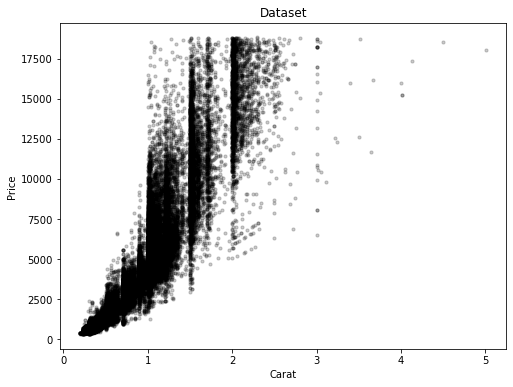

In [4]:
plt.figure(figsize=[8, 6])
plt.scatter(df.carat, df.price, color='black', alpha=0.2, s=10)
plt.title('Dataset')
plt.xlabel("Carat")
plt.ylabel("Price")
plt.show()

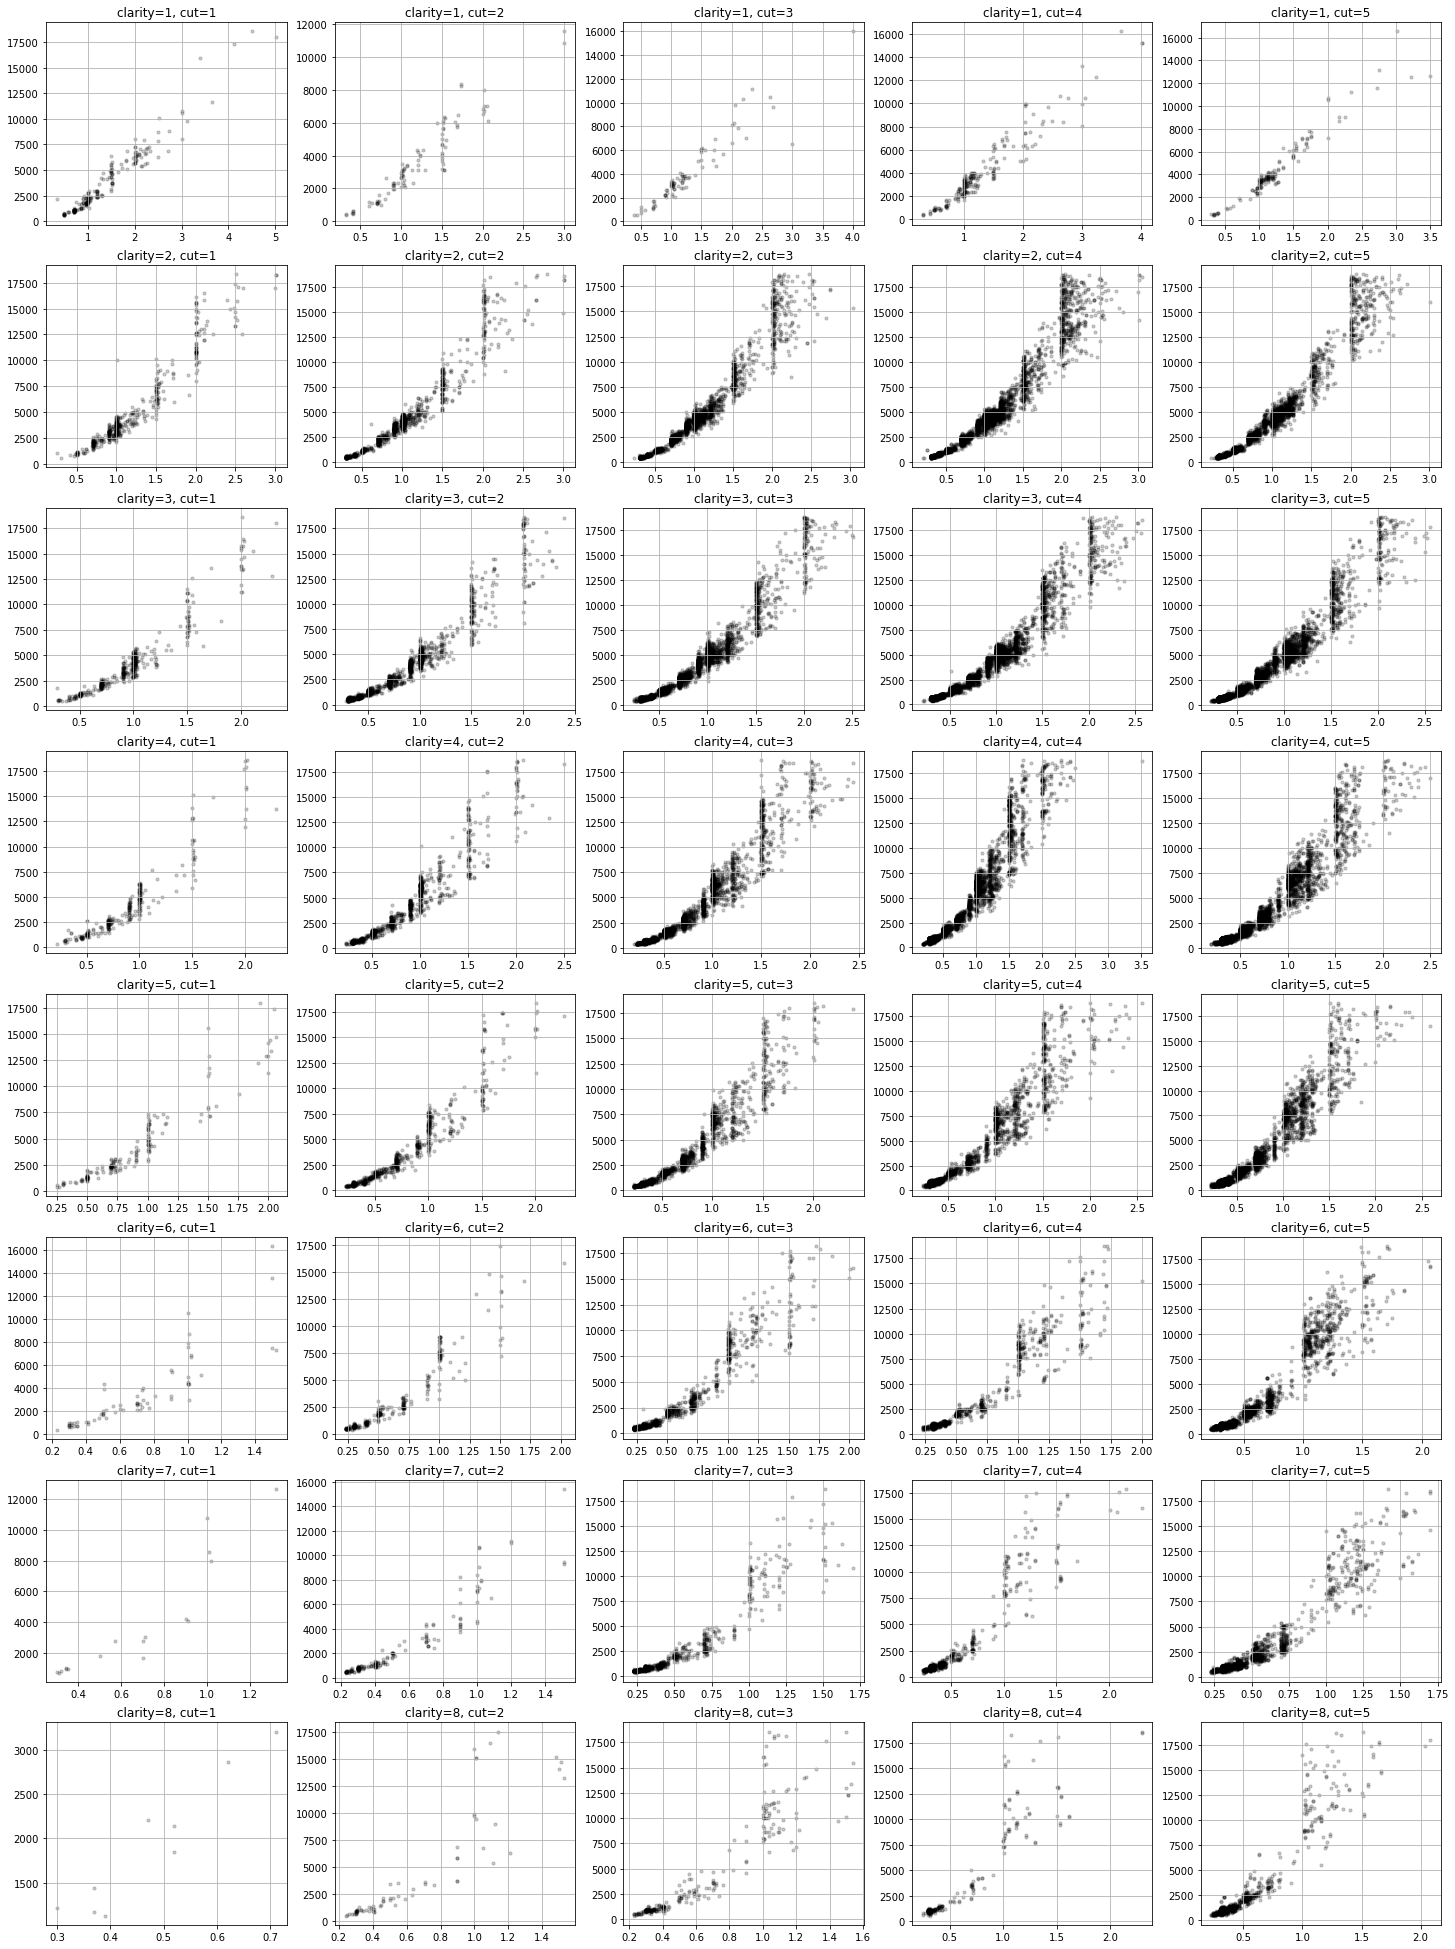

In [5]:
fig, axs = plt.subplots(8,5)
fig.set_size_inches(25, 35)
for i in range(0,8):
    for j in range(0,5):
        df_temp = df.loc[df['clarity'] == i+1]
        df_temp = df_temp.loc[df_temp['cut'] == j+1]
        axs[i][j].scatter(df_temp.carat, df_temp.price, color='black', alpha=0.2, s=10)
        axs[i][j].grid()
        axs[i][j].set_title(f'clarity={i+1}, cut={j+1}')
plt.show()

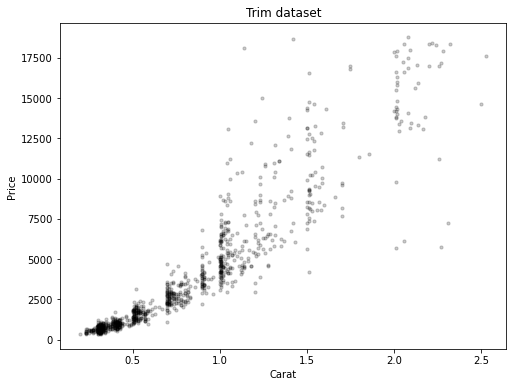

In [6]:
df_trim = df.sample(n = 1000)
df_trim.reset_index(drop=True, inplace=True)

plt.figure(figsize=[8, 6])
plt.scatter(df_trim.carat, df_trim.price, color='black', alpha=0.2, s=10)
plt.title('Trim dataset')
plt.xlabel("Carat")
plt.ylabel("Price")
plt.show()

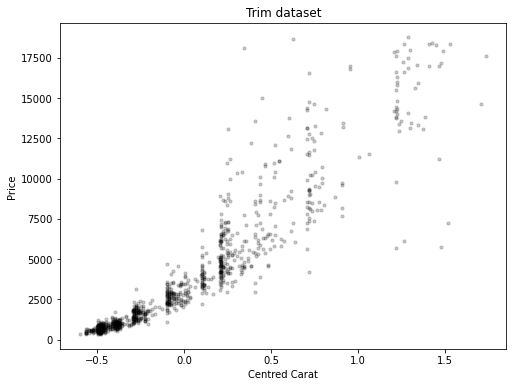

In [7]:
df_trim['c_carat'] = df_trim.carat - df_trim.carat.mean()

plt.figure(figsize=[8, 6])
plt.scatter(df_trim.c_carat, df_trim.price, color='black', alpha=0.2, s=10)
plt.title('Trim dataset')
plt.xlabel("Centred Carat")
plt.ylabel("Price")
plt.show()

---
# Data Analysis
[***Return to table of contents***](#table-of-contents)

For analysis we have created 3 bayesian models.

* Model 1 - uses 1st degree polynomial (a linear function)
* Model 2 - 

Expanding the first model by increasing the order of the polynomial allows for a better fit of the model to the observations, in terms of the data, and for value prediction. The third model is the departure from polynomial regression to the simulating from a Gaussian Process conditional on non-Gaussian observations.

The equations, parameters and differences of individual models are presented in the corresponding chapters.

---

---
## Model 1 - 2 predictors
[***Return to table of contents***](#table-of-contents)

Our first model was based on 1st degree polynomial function.

Model has form:

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$

With parameter distributions set as follows:
$$ \alpha \sim \mathrm{Normal}(193, 5) $$
$$ \beta \sim \mathrm{Normal}(5625, 5) $$
$$ \sigma \sim \mathrm{Exponential}(5) $$

The required input data is the set of carats for which the user wants to make a prediction.

---
### Model 1 - Prior predictive check
[***Return to table of contents***](#table-of-contents)

First step is prior predicive check whether parameter values and distributions "make sense".

Parameters simulated from priors are a result of the model definition. The first order polynomial requires two parameters to equate the line, and the third is the width of the fit.

On the basis of the obtained parameter values, it can be concluded that the prior selection was successful, the values ​​are in line with the expectations.

On the basis of the obtained straight line fit to the measurements, it can be concluded that the prior predictive was successful. The obtained lines pass through the points as expected.

Priors were selected on the basis of the polynomial equation in the chapter [Plotting dataset and polynomial fitting](#plotting-dataset-and-polynomial-fitting).

![](./images/model_1_ppc.png)

---

In [8]:
model_1_ppc = CmdStanModel(stan_file='stanfiles/model_1_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [9]:
data_sim={'N':len(df_trim), 'carat': df_trim.carat, 'clarity': df_trim.clarity}
model_1_sim = model_1_ppc.sample(data=data_sim, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=12345678)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


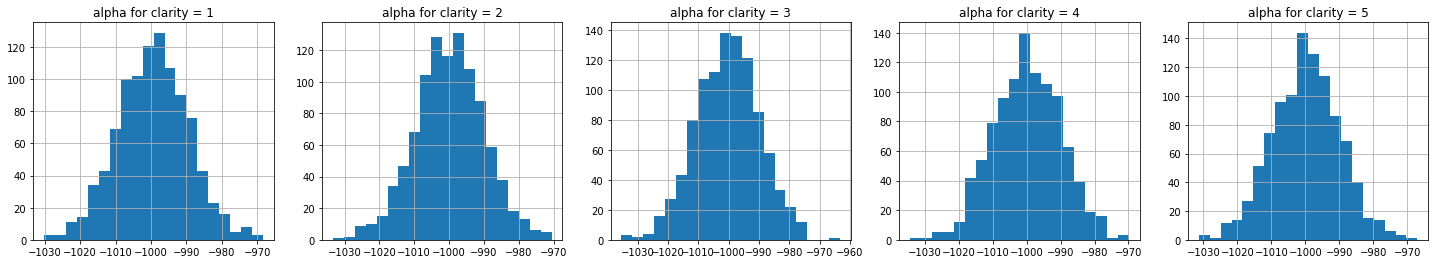

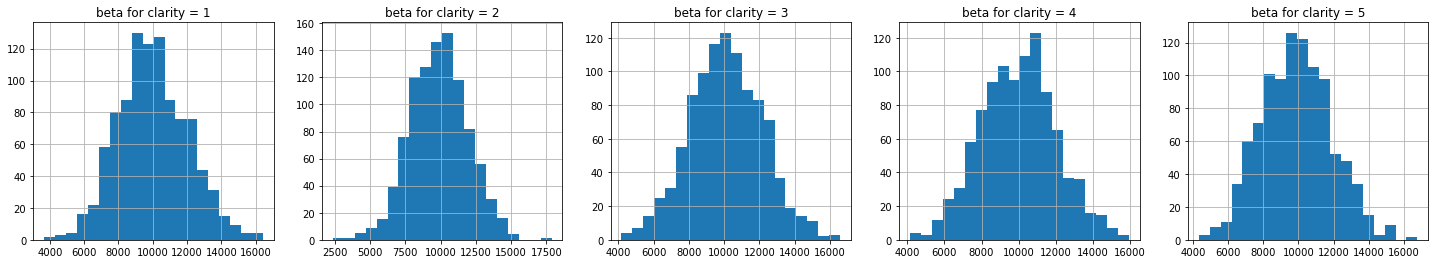

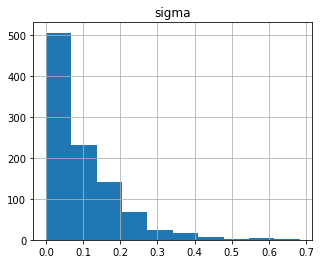

,mean,sd,hdi_3%,hdi_97%
alpha_clarity[0],-999.38,10.00,-1017.91,-980.58
alpha_clarity[1],-999.87,9.83,-1018.40,-981.87
alpha_clarity[2],-1000.26,10.41,-1020.43,-981.08
alpha_clarity[3],-999.88,9.84,-1018.00,-982.33
alpha_clarity[4],-999.79,9.81,-1019.38,-983.02
alpha_clarity[5],-999.83,10.24,-1018.90,-980.53
alpha_clarity[6],-999.73,10.21,-1019.24,-981.66
alpha_clarity[7],-999.60,10.13,-1017.34,-979.50
beta_clarity[0],10011.05,2031.60,6678.41,14201.80
beta_clarity[1],9885.19,2018.80,6403.72,13764.90


In [10]:
alpha_clarity_sim = pd.DataFrame(model_1_sim.stan_variable('alpha_clarity'))
beta_clarity_sim = pd.DataFrame(model_1_sim.stan_variable('beta_clarity'))
sigma_sim = model_1_sim.stan_variable('sigma')
price_sim = model_1_sim.stan_variable('price')

fig, axs = plt.subplots(1,5)
fig.set_size_inches(25, 4)
for i in range(0,5):
    axs[i].hist(alpha_clarity_sim[i], bins=20)
    axs[i].set_title(f"alpha for clarity = {i+1}")
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,5)
fig.set_size_inches(25, 4)
for i in range(0,5):
    axs[i].hist(beta_clarity_sim[i], bins=20)
    axs[i].set_title(f"beta for clarity = {i+1}")
    axs[i].grid()
plt.show()

plt.figure(figsize=[5, 4])
plt.hist(sigma_sim)
plt.title('sigma')
plt.grid()
plt.show()

az.summary(model_1_sim, var_names=['alpha_clarity', 'beta_clarity', 'sigma'], round_to=2, kind='stats')

On the basis of the obtained parameter values, it can be concluded that the prior selection was successful, the values ​​are in line with the expectations.

In [11]:
def calcQuants(x, y):
    qlvls = [0, 1]
    quansList = [[], []]
    for i in range(y.shape[-1]):
        temp = y[:, i]
        for q, lvl in zip(quansList, qlvls):
            q.append(np.quantile(temp, lvl))
    #for quantile in quansList[:]:
    #    plt.scatter(x, quantile)
    #plt.legend(['min', '5%', '25%', '50%', '75%', '95%', 'max'])
    return quansList

def quantsExtremes(df, y, q):
    carat_uq = df.carat.unique()
    carat_uq = sorted(carat_uq)
    quansList = calcQuants(df.carat, y)
    caratQuantDict = dict()
    for carat_val in carat_uq:
        caratList = np.array(df.carat.tolist())
        idxs = np.where(caratList == carat_val)[0]
        qval = quansList[q][idxs[0]]
        for i in idxs:
            if q == 0 and quansList[q][i] < qval:
                qval = quansList[q][i]
            elif q == 1 and quansList[q][i] > qval:
                qval = quansList[q][i]
        if q == 0:
            caratQuantDict[carat_val] = qval
        elif q == 1:
            caratQuantDict[carat_val] = qval
    return caratQuantDict

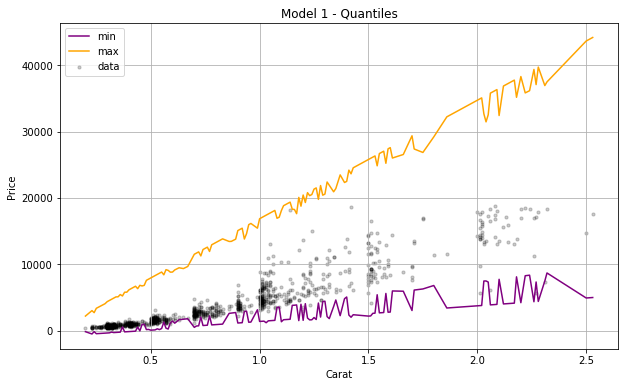

In [12]:
plt.figure(figsize=[10, 6])

caratQuantMinDict = quantsExtremes(df_trim, price_sim, 0)
caratMin = list(caratQuantMinDict.keys())
quantMin = list(caratQuantMinDict.values())

caratQuantMaxDict = quantsExtremes(df_trim, price_sim, 1)
caratMax = list(caratQuantMaxDict.keys())
quantMax = list(caratQuantMaxDict.values())

plt.plot(caratMin, quantMin, color = 'purple')
plt.plot(caratMax, quantMax, color = 'orange')
plt.scatter(df_trim.carat, df_trim.price, color='black', alpha=0.2, s=10)
plt.xlabel("Carat")
plt.ylabel("Price")
plt.title("Model 1 - Quantiles")
plt.legend(['min', 'max', 'data'])
plt.grid()
plt.show()

On the basis of the obtained straight line fit to the measurements, it can be concluded that the prior predictive was successful. The obtained lines pass through the points as expected.

---
### Model 1 - Posterior analysis
[***Return to table of contents***](#table-of-contents)

After confirming that the priors values and trajectories are correct we can start a proper analysis.

No issues were detected during sampling.

A full model for 1st degree polynomial regression was created:

![](./images/model_lr.png)

---

In [13]:
model_1 = CmdStanModel(stan_file='stanfiles/model_1.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [14]:
data_sim={'N':len(df_trim), 'carat': df_trim.carat, 'clarity': df_trim.clarity, 'price': df_trim.price}
model_1_fit = model_1.sample(data=data_sim)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


---

### Model 1 - model parameters
[***Return to table of contents***](#table-of-contents)

We can also extract stan variables that are used in the final price prediction equation.

Based on the presented graphs and histograms of parameters, it can be concluded that parameter values ​​are relatively concentrated. 

Their slight dispersion is good due to the fact that it is not possible to perfectly match the lines to observations.

---

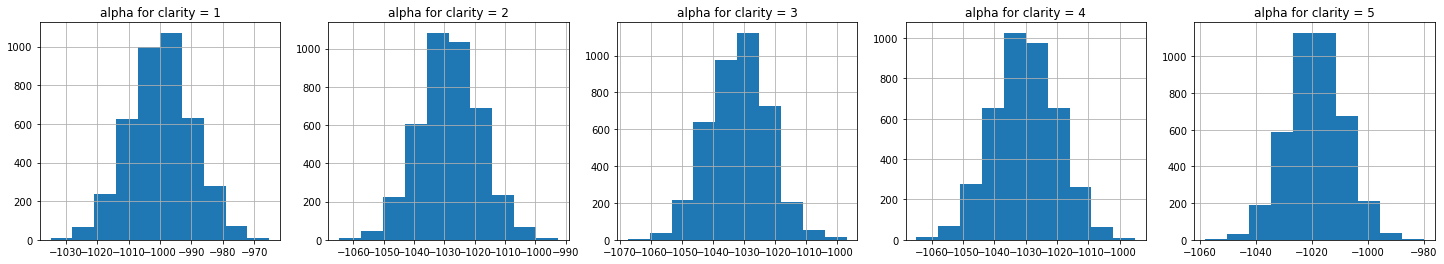

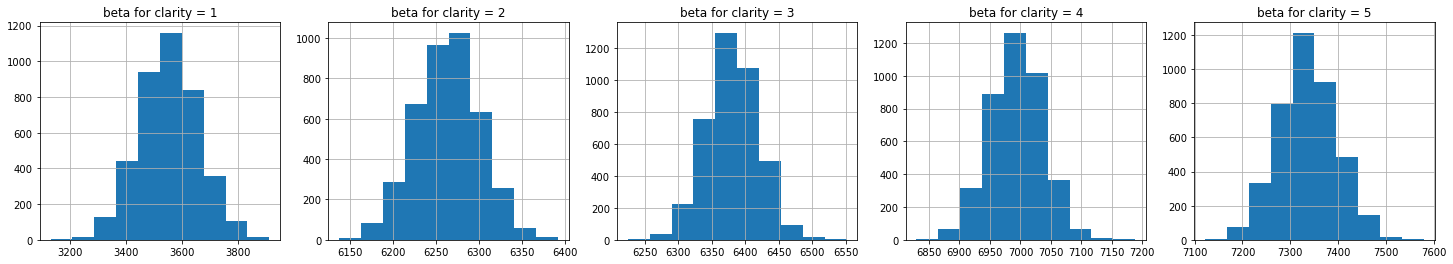

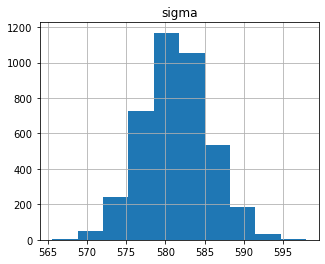

,mean,sd,hdi_3%,hdi_97%
alpha_clarity[0],-999.72,9.97,-1018.01,-980.47
alpha_clarity[1],-1028.30,10.00,-1047.47,-1009.85
alpha_clarity[2],-1031.68,9.61,-1050.36,-1014.51
alpha_clarity[3],-1030.05,10.20,-1050.46,-1012.13
alpha_clarity[4],-1018.54,10.12,-1037.90,-1000.55
alpha_clarity[5],-1008.36,10.12,-1028.10,-990.33
alpha_clarity[6],-1010.08,9.65,-1027.81,-991.81
alpha_clarity[7],-1006.85,9.84,-1024.89,-987.74
beta_clarity[0],3553.76,104.91,3363.91,3759.69
beta_clarity[1],6263.50,37.45,6189.95,6330.08


In [15]:
alpha_clarity_fit = pd.DataFrame(model_1_fit.stan_variable('alpha_clarity'))
beta_clarity_fit = pd.DataFrame(model_1_fit.stan_variable('beta_clarity'))
sigma_fit = model_1_fit.stan_variable('sigma')

fig, axs = plt.subplots(1,5)
fig.set_size_inches(25, 4)
for i in range(0,5):
    axs[i].hist(alpha_clarity_fit[i])
    axs[i].set_title(f"alpha for clarity = {i+1}")
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,5)
fig.set_size_inches(25, 4)
for i in range(0,5):
    axs[i].hist(beta_clarity_fit[i])
    axs[i].set_title(f"beta for clarity = {i+1}")
    axs[i].grid()
plt.show()

plt.figure(figsize=[5, 4])
plt.hist(sigma_fit)
plt.title('sigma')
plt.grid()
plt.show()

az.summary(model_1_fit, var_names=['alpha_clarity', 'beta_clarity', 'sigma'], round_to=2, kind='stats')

---

### Model 1 - evaluation

[***Return to table of contents***](#table-of-contents)

We can now observe the results.

---

#### Model 1 - quantiles
[***Return to table of contents***](#table-of-contents)

After simulating we can analyze predictions. The quantiles follow a linear function. The right side of the plot gets squished as there are fewer diamonds of higher weights.

---

In [31]:
data = model_1_fit.draws_pd()
price_sims = data[data.columns[len(df_trim)+18:len(df_trim)+1018]]
#print(price_sims)

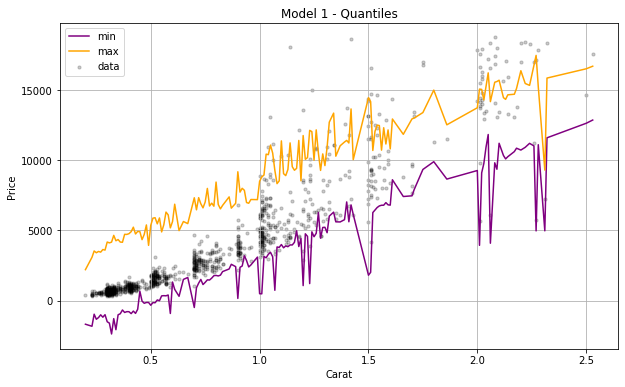

In [17]:
price_sim = model_1_fit.stan_variable('price_sim')
plt.figure(figsize=[10, 6])

caratQuantMinDict = quantsExtremes(df_trim, price_sim, 0)
caratMin = list(caratQuantMinDict.keys())
quantMin = list(caratQuantMinDict.values())

caratQuantMaxDict = quantsExtremes(df_trim, price_sim, 1)
caratMax = list(caratQuantMaxDict.keys())
quantMax = list(caratQuantMaxDict.values())

plt.plot(caratMin, quantMin, color = 'purple')
plt.plot(caratMax, quantMax, color = 'orange')
plt.scatter(df_trim.carat, df_trim.price, color='black', alpha=0.2, s=10)
plt.xlabel("Carat")
plt.ylabel("Price")
plt.title("Model 1 - Quantiles")
plt.legend(['min', 'max', 'data'])
plt.grid()
plt.show()

---
#### Model 1 - predictions and density plot
[***Return to table of contents***](#table-of-contents)

As we can see the model is not sufficient to describe the phenomenon. 

While it's somewhat true for a narrow band of weights (about 1-1.5 carats), it is not accurate for low and med-high gems. It also gets progressively worse as true diamond prices plateau above 3 carat mark, most likely due to higher chances of defects.

The model predicted that most diamonds oscillate around value of 10 000 while the ground truth is exacly opposite, there are more low and high costs diamonds rather than the mid ones.

---

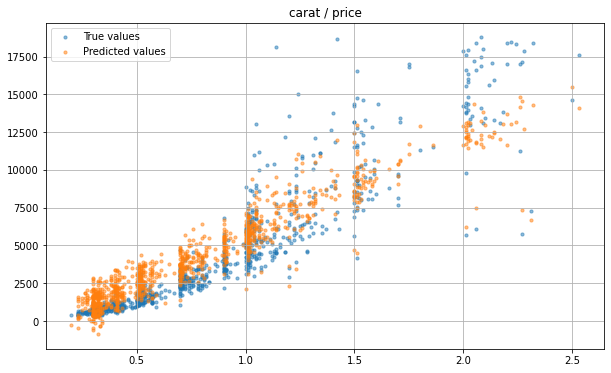

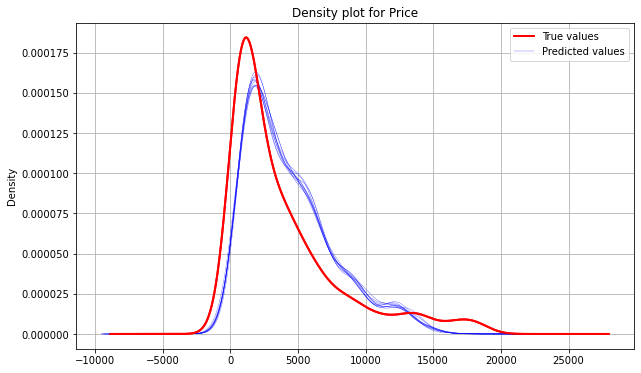

In [18]:
price_sim = model_1_fit.stan_variable('price_sim')
plt.figure(figsize=[10,6])
plt.scatter(df_trim.carat, df_trim.price, alpha=0.5, s=10)
plt.scatter(df_trim.carat, price_sim[0], alpha=0.5, s=10)
plt.title("carat / price")
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()

df_trim.price.plot.density(figsize=(10,6), linewidth=2, color='red')
for i in range(0,10):
    price_sims.iloc[i].plot.density(linewidth=0.25, color='blue')
df_trim.price.plot.density(figsize=(10,6), linewidth=2, color='red')
plt.title('Density plot for Price')
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()

---
## Model 2 - Added 3rd predictor
[***Return to table of contents***](#table-of-contents)

Our first model was based on 1st degree polynomial function.

Model has form:

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$

With parameter distributions set as follows:
$$ \alpha \sim \mathrm{Normal}(193, 5) $$
$$ \beta \sim \mathrm{Normal}(5625, 5) $$
$$ \sigma \sim \mathrm{Exponential}(5) $$

The required input data is the set of carats for which the user wants to make a prediction.

---
### Model 2 - Prior predictive check
[***Return to table of contents***](#table-of-contents)

First step is prior predicive check whether parameter values and distributions "make sense".

Parameters simulated from priors are a result of the model definition. The first order polynomial requires two parameters to equate the line, and the third is the width of the fit.

On the basis of the obtained parameter values, it can be concluded that the prior selection was successful, the values ​​are in line with the expectations.

On the basis of the obtained straight line fit to the measurements, it can be concluded that the prior predictive was successful. The obtained lines pass through the points as expected.

Priors were selected on the basis of the polynomial equation in the chapter [Plotting dataset and polynomial fitting](#plotting-dataset-and-polynomial-fitting).

![](./images/model_1_ppc.png)

---

In [19]:
model_2_ppc = CmdStanModel(stan_file='stanfiles/model_2_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [20]:
data_sim={'N':len(df_trim), 'carat': df_trim.carat, 'cut': df_trim.cut, 'clarity': df_trim.clarity}
model_2_sim = model_2_ppc.sample(data=data_sim, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=12345678)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


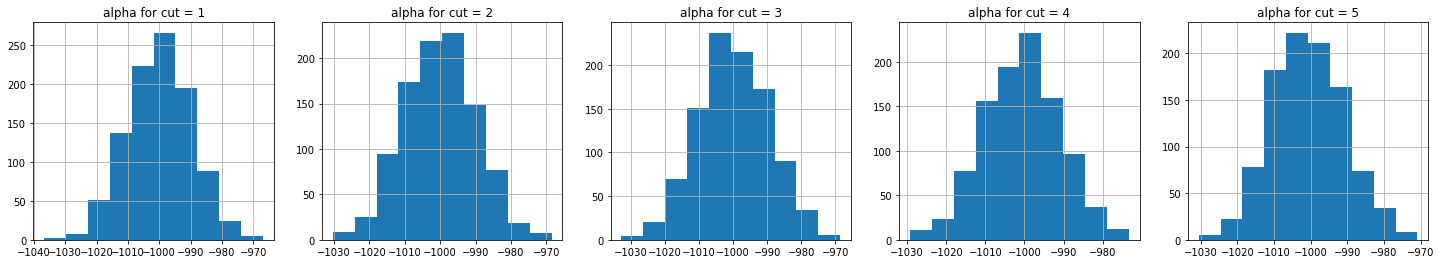

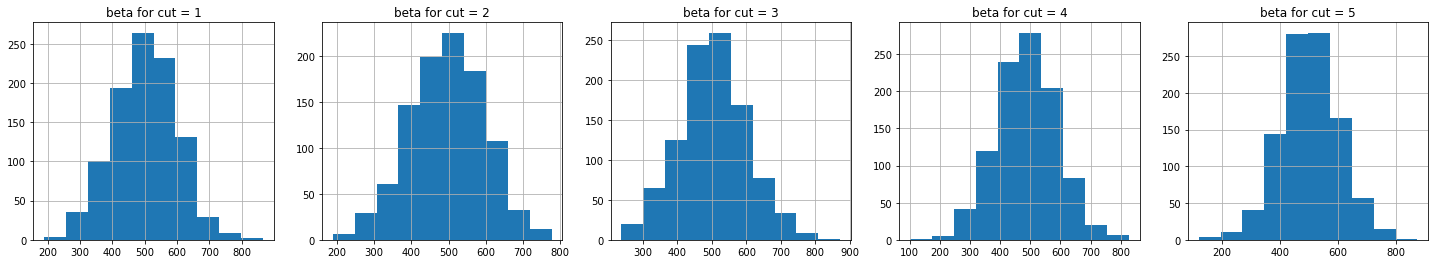

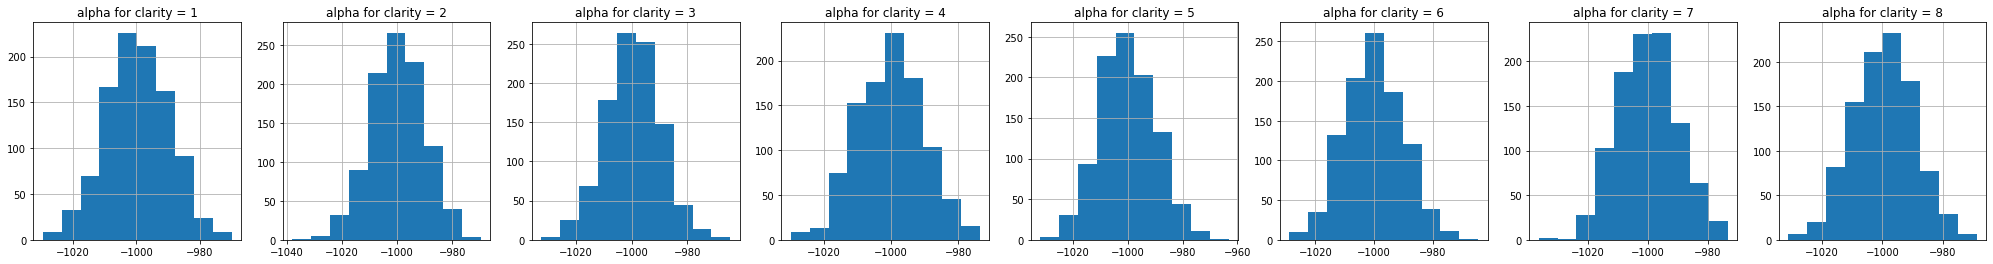

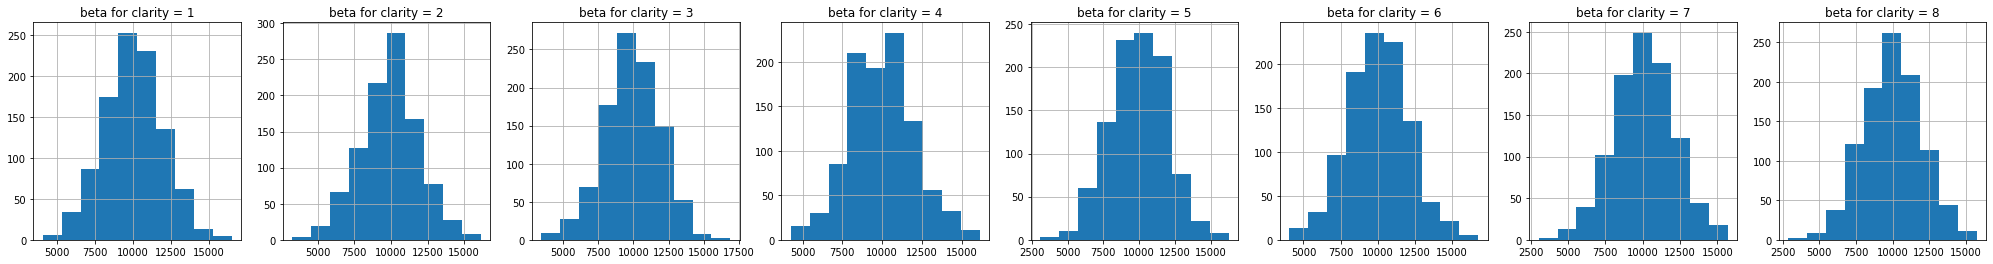

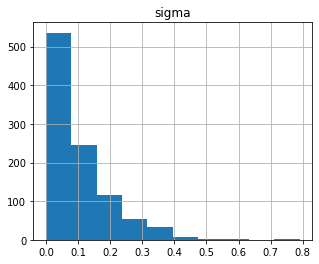

,mean,sd,hdi_3%,hdi_97%
alpha_cut[0],-999.93,10.15,-1018.83,-981.37
alpha_cut[1],-1000.15,10.11,-1016.77,-980.53
alpha_cut[2],-999.82,10.31,-1018.27,-979.77
alpha_cut[3],-1000.62,9.66,-1017.00,-981.90
alpha_cut[4],-1000.67,9.84,-1017.88,-981.41
beta_cut[0],501.41,98.19,301.54,659.84
beta_cut[1],495.03,100.69,307.68,688.09
beta_cut[2],503.49,97.83,314.95,692.28
beta_cut[3],488.05,101.48,300.60,666.09
beta_cut[4],502.83,100.88,325.59,713.06


In [21]:
alpha_cut_sim = pd.DataFrame(model_2_sim.stan_variable('alpha_cut'))
alpha_clarity_sim = pd.DataFrame(model_2_sim.stan_variable('alpha_clarity'))
beta_cut_sim = pd.DataFrame(model_2_sim.stan_variable('beta_cut'))
beta_clarity_sim = pd.DataFrame(model_2_sim.stan_variable('beta_clarity'))
sigma_sim = model_2_sim.stan_variable('sigma')
price_sim = model_2_sim.stan_variable('price')

fig, axs = plt.subplots(1,5)
fig.set_size_inches(25, 4)
for i in range(0,5):
    axs[i].hist(alpha_cut_sim[i])
    axs[i].set_title(f"alpha for cut = {i+1}")
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,5)
fig.set_size_inches(25, 4)
for i in range(0,5):
    axs[i].hist(beta_cut_sim[i])
    axs[i].set_title(f"beta for cut = {i+1}")
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,8)
fig.set_size_inches(35, 4)
for i in range(0,8):
    axs[i].hist(alpha_clarity_sim[i])
    axs[i].set_title(f"alpha for clarity = {i+1}")
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,8)
fig.set_size_inches(35, 4)
for i in range(0,8):
    axs[i].hist(beta_clarity_sim[i])
    axs[i].set_title(f"beta for clarity = {i+1}")
    axs[i].grid()
plt.show()

plt.figure(figsize=[5, 4])
plt.hist(sigma_sim)
plt.title('sigma')
plt.grid()
plt.show()

az.summary(model_2_sim, var_names=['alpha_cut', 'beta_cut', 'alpha_clarity', 'beta_clarity', 'sigma'], round_to=2, kind='stats')

On the basis of the obtained parameter values, it can be concluded that the prior selection was successful, the values ​​are in line with the expectations.

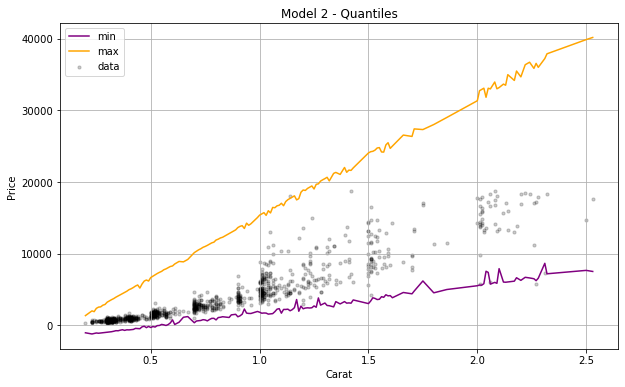

In [22]:
price_sim = model_2_sim.stan_variable('price')
plt.figure(figsize=[10, 6])

caratQuantMinDict = quantsExtremes(df_trim, price_sim, 0)
caratMin = list(caratQuantMinDict.keys())
quantMin = list(caratQuantMinDict.values())

caratQuantMaxDict = quantsExtremes(df_trim, price_sim, 1)
caratMax = list(caratQuantMaxDict.keys())
quantMax = list(caratQuantMaxDict.values())

plt.plot(caratMin, quantMin, color = 'purple')
plt.plot(caratMax, quantMax, color = 'orange')
plt.scatter(df_trim.carat, df_trim.price, color='black', alpha=0.2, s=10)
plt.xlabel("Carat")
plt.ylabel("Price")
plt.title("Model 2 - Quantiles")
plt.legend(['min', 'max', 'data'])
plt.grid()
plt.show()

On the basis of the obtained straight line fit to the measurements, it can be concluded that the prior predictive was successful. The obtained lines pass through the points as expected.

---
### Model 2 - Posterior analysis
[***Return to table of contents***](#table-of-contents)

After confirming that the priors values and trajectories are correct we can start a proper analysis.

No issues were detected during sampling.

A full model for 1st degree polynomial regression was created:

![](./images/model_lr.png)

---

In [23]:
model_2 = CmdStanModel(stan_file='stanfiles/model_2.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [24]:
data_sim={'N':len(df_trim), 'carat': df_trim.carat, 'cut': df_trim.cut, 'clarity': df_trim.clarity, 'price': df_trim.price}
model_2_fit = model_2.sample(data=data_sim)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


---

### Model 2 - model parameters
[***Return to table of contents***](#table-of-contents)

We can also extract stan variables that are used in the final price prediction equation.

Based on the presented graphs and histograms of parameters, it can be concluded that parameter values ​​are relatively concentrated. 

Their slight dispersion is good due to the fact that it is not possible to perfectly match the lines to observations.

---

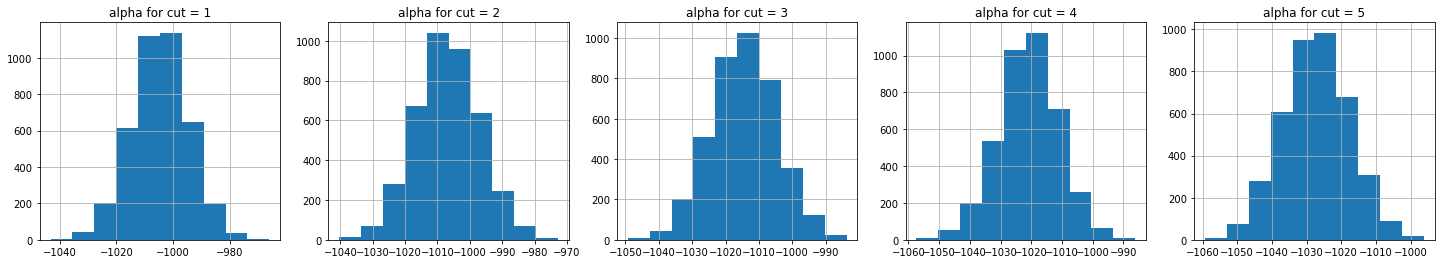

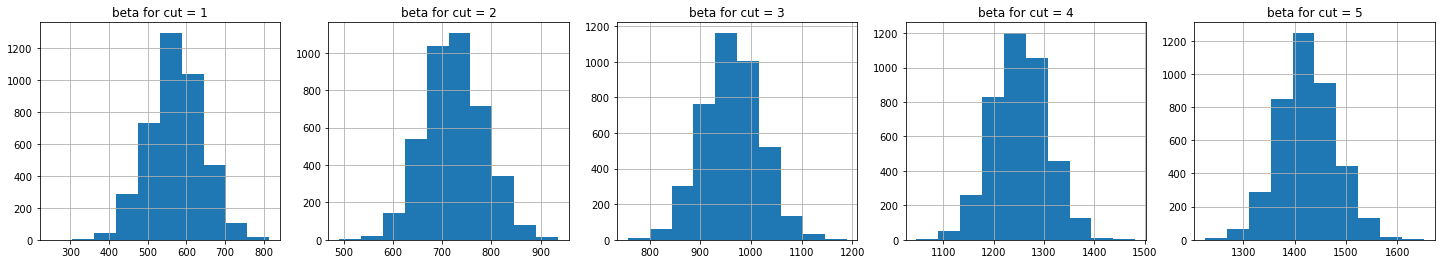

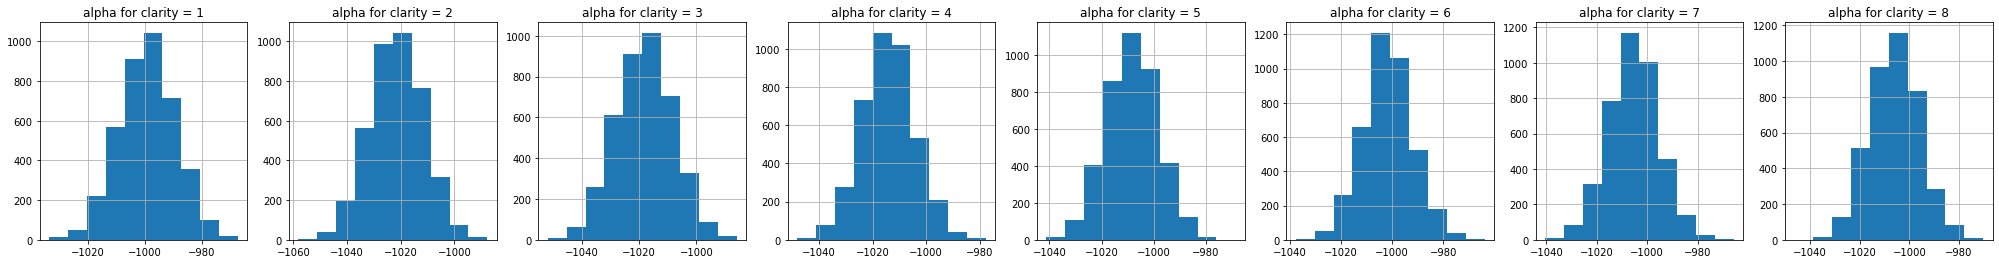

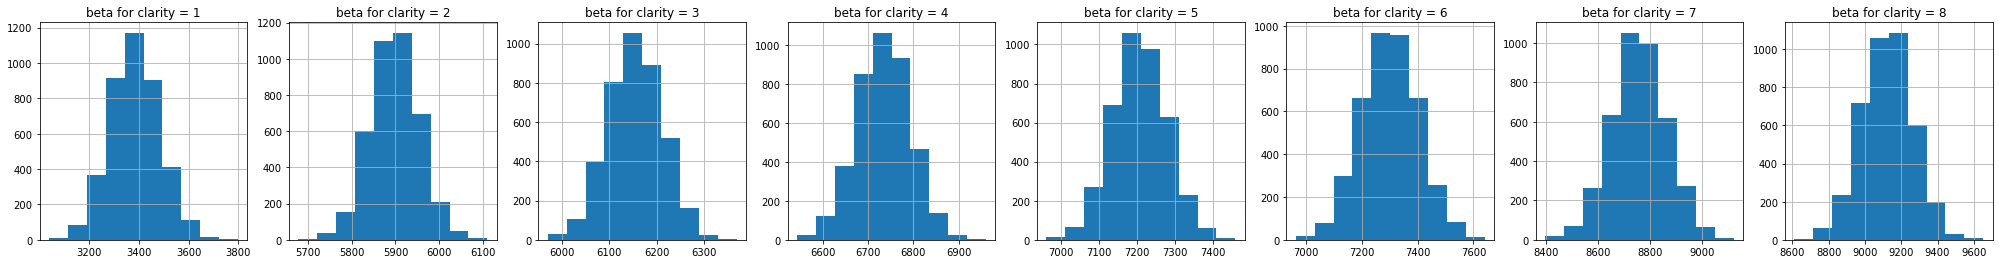

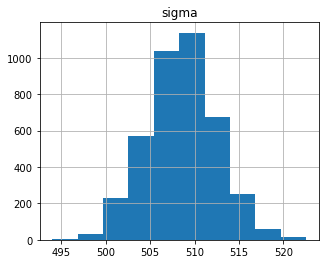

,mean,sd,hdi_3%,hdi_97%
alpha_cut[0],-1004.60,9.99,-1023.68,-986.20
alpha_cut[1],-1006.91,9.96,-1025.65,-988.26
alpha_cut[2],-1014.53,9.84,-1032.81,-996.27
alpha_cut[3],-1020.85,9.76,-1039.27,-1002.74
alpha_cut[4],-1027.30,9.59,-1045.00,-1009.21
beta_cut[0],572.31,69.45,436.19,696.01
beta_cut[1],724.82,60.60,617.51,842.22
beta_cut[2],961.81,57.08,854.43,1066.65
beta_cut[3],1251.74,53.99,1150.88,1352.92
beta_cut[4],1423.69,54.71,1322.10,1530.63


In [25]:
alpha_cut_fit = pd.DataFrame(model_2_fit.stan_variable('alpha_cut'))
alpha_clarity_fit = pd.DataFrame(model_2_fit.stan_variable('alpha_clarity'))
beta_cut_fit = pd.DataFrame(model_2_fit.stan_variable('beta_cut'))
beta_clarity_fit = pd.DataFrame(model_2_fit.stan_variable('beta_clarity'))
sigma_fit = model_2_fit.stan_variable('sigma')

fig, axs = plt.subplots(1,5)
fig.set_size_inches(25, 4)
for i in range(0,5):
    axs[i].hist(alpha_cut_fit[i])
    axs[i].set_title(f"alpha for cut = {i+1}")
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,5)
fig.set_size_inches(25, 4)
for i in range(0,5):
    axs[i].hist(beta_cut_fit[i])
    axs[i].set_title(f"beta for cut = {i+1}")
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,8)
fig.set_size_inches(35, 4)
for i in range(0,8):
    axs[i].hist(alpha_clarity_fit[i])
    axs[i].set_title(f"alpha for clarity = {i+1}")
    axs[i].grid()
plt.show()

fig, axs = plt.subplots(1,8)
fig.set_size_inches(35, 4)
for i in range(0,8):
    axs[i].hist(beta_clarity_fit[i])
    axs[i].set_title(f"beta for clarity = {i+1}")
    axs[i].grid()
plt.show()

plt.figure(figsize=[5, 4])
plt.hist(sigma_fit)
plt.title('sigma')
plt.grid()
plt.show()

az.summary(model_2_fit, var_names=['alpha_cut', 'beta_cut', 'alpha_clarity', 'beta_clarity', 'sigma'], round_to=2, kind='stats')

---

### Model 2 - evaluation

[***Return to table of contents***](#table-of-contents)

We can now observe the results.

---

#### Model 2 - quantiles
[***Return to table of contents***](#table-of-contents)

After simulating we can analyze predictions. The quantiles follow a linear function. The right side of the plot gets squished as there are fewer diamonds of higher weights.

---

In [30]:
data = model_2_fit.draws_pd()
price_sims = data[data.columns[len(df_trim)+34:len(df_trim)+1034]]
#print(price_sims)

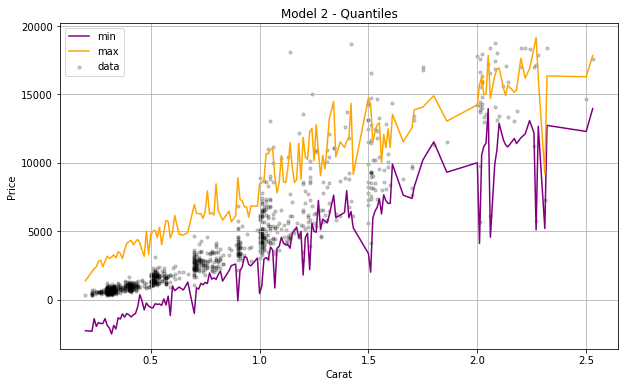

In [27]:
price_sim = model_2_fit.stan_variable('price_sim')
plt.figure(figsize=[10, 6])

caratQuantMinDict = quantsExtremes(df_trim, price_sim, 0)
caratMin = list(caratQuantMinDict.keys())
quantMin = list(caratQuantMinDict.values())

caratQuantMaxDict = quantsExtremes(df_trim, price_sim, 1)
caratMax = list(caratQuantMaxDict.keys())
quantMax = list(caratQuantMaxDict.values())

plt.plot(caratMin, quantMin, color = 'purple')
plt.plot(caratMax, quantMax, color = 'orange')
plt.scatter(df_trim.carat, df_trim.price, color='black', alpha=0.2, s=10)
plt.xlabel("Carat")
plt.ylabel("Price")
plt.title("Model 2 - Quantiles")
plt.legend(['min', 'max', 'data'])
plt.grid()
plt.show()

---
#### Model 2 - predictions and density plot
[***Return to table of contents***](#table-of-contents)

As we can see the model is not sufficient to describe the phenomenon. 

While it's somewhat true for a narrow band of weights (about 1-1.5 carats), it is not accurate for low and med-high gems. It also gets progressively worse as true diamond prices plateau above 3 carat mark, most likely due to higher chances of defects.

The model predicted that most diamonds oscillate around value of 10 000 while the ground truth is exacly opposite, there are more low and high costs diamonds rather than the mid ones.

---

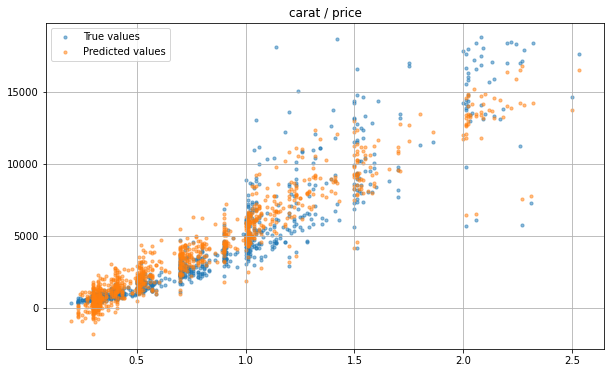

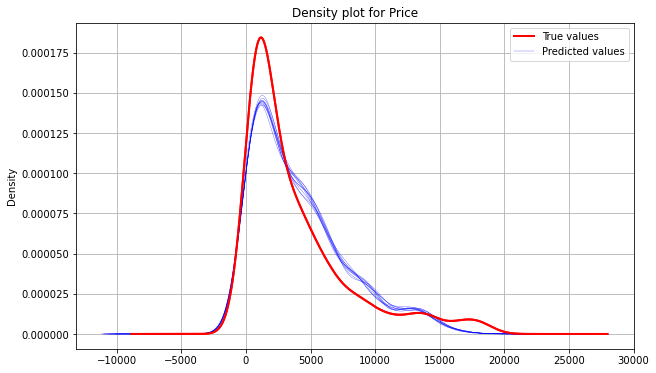

In [28]:
price_sim = model_2_fit.stan_variable('price_sim')
plt.figure(figsize=[10,6])
plt.scatter(df_trim.carat, df_trim.price, alpha=0.5, s=10)
plt.scatter(df_trim.carat, price_sim[1], alpha=0.5, s=10)
plt.title("carat / price")
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()

df_trim.price.plot.density(figsize=(10,6), linewidth=2, color='red')
for i in range(0,10):
    price_sims.iloc[i].plot.density(linewidth=0.25, color='blue')
df_trim.price.plot.density(figsize=(10,6), linewidth=2, color='red')
plt.title('Density plot for Price')
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()

---

## Model Comparison
[***Return to table of contents***](#table-of-contents)

Leave-one-out cross-validation (LOO) and the widely applicable information criterion (WAIC) are methods for estimating pointwise out-of-sample prediction accuracy from a fitted Bayesian model using the log-likelihood evaluated at the posterior simulations of the parameter values. 
The comparison function used allows the models to be assessed against each of these criteria, ordering them from best to worst.

---

### PSIS-LOO Criterion
[***Return to table of contents***](#table-of-contents)

Based on the comparison of the models using the PSIS-LOO criterion, it can be concluded that:
* 4th degree polynomial regression has the lowest rank (which means the best model of all)
* 4th degree polynomial regression has the highest out-of-sample predictive fit ('loo' column), while the gaussian process has the lowest,
* 4th degree polynomial regression has the highest probability of the correctness of the model ('weight' column), while the gaussian process has the lowest,
* standard error of the difference information criteria between each model and the top ranked model ('dse' column) show that the Gaussian process model deviates from the polynomial much more than linear,
* for all models there is a warning that indicates that the computation of the information criteria may not be reliable.

---

In [ ]:
fit_1 = az.from_cmdstanpy(posterior=model_1_fit,
                            log_likelihood="log_lik",
                            posterior_predictive="price_sim",
                            observed_data=df_trim['price'])

fit_2 = az.from_cmdstanpy(posterior=model_2_fit,
                            log_likelihood="log_lik",
                            posterior_predictive="price_sim",
                            observed_data=df_trim['price'])

compare_dict = {"Model_1": fit_1, "Model_2": fit_2}

comp_loo = az.compare(compare_dict, ic = "loo")
print('\n')
print(comp_loo)
az.plot_compare(comp_loo)

---

### WAIC Criterion
[***Return to table of contents***](#table-of-contents)

Based on the comparison of the models using the WAIC criterion, it can be concluded that the conclusions are identical to the previous criterion, i.e.:
* 4th degree polynomial regression has the lowest rank (which means the best model of all)
* 4th degree polynomial regression has the highest out-of-sample predictive fit ('waic' column), while the gaussian process has the lowest,
* 4th degree polynomial regression has the highest probability of the correctness of the model ('weight' column), while the gaussian process has the lowest,
* standard error of the difference information criteria between each model and the top ranked model ('dse' column) show that the Gaussian process model deviates from the polynomial much more than linear,
* for all models there is a warning that indicates that the computation of the information criteria may not be reliable.

---

e:\Programowanie\Anaconda\envs\marcinbereznicki\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
e:\Programowanie\Anaconda\envs\marcinbereznicki\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
e:\Programowanie\Anaconda\envs\marcinbereznicki\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less 



         rank           loo       p_loo       d_loo    weight          se  \
Model_2     0 -10294.349652  193.762762    0.000000  0.838908  282.582854   
Model_1     1 -10768.091670  150.037094  473.742018  0.161092  272.497283   

               dse  warning loo_scale  
Model_2   0.000000     True       log  
Model_1  77.477155     True       log  


e:\Programowanie\Anaconda\envs\marcinbereznicki\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
e:\Programowanie\Anaconda\envs\marcinbereznicki\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(




         rank          waic      p_waic      d_waic    weight          se  \
Model_2     0 -10298.859711  198.272821    0.000000  0.839523  285.205114   
Model_1     1 -10772.023353  153.968777  473.163642  0.160477  274.274939   

               dse  warning waic_scale  
Model_2   0.000000     True        log  
Model_1  78.059848     True        log  


e:\Programowanie\Anaconda\envs\marcinbereznicki\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


<AxesSubplot:xlabel='Log'>

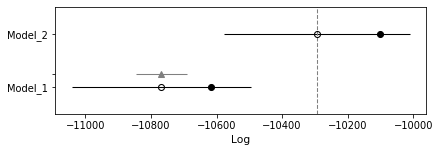

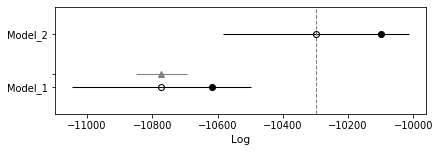

In [29]:
comp_waic = az.compare(compare_dict, ic = "waic")
print('\n')
print(comp_waic)
az.plot_compare(comp_waic)

---

# Model Comparison - conclusions
[***Return to table of contents***](#table-of-contents)

Comparing the models, can agree with the results that the polynomial regression model produces the best results. If we are talking about the worst model, on the basis of the obtained price value prediction charts it can be concluded that the Gaussian process coped better with the fitting than the linear regression. This opinion differs from the result of the information criterion. As mentioned earlier, polynomial regression gave a satisfactory result for the given range. For higher carat values, the results could be different, but due to the fact that they are very rare, they were not taken into account in the final evaluation of the correctness of the model.

---